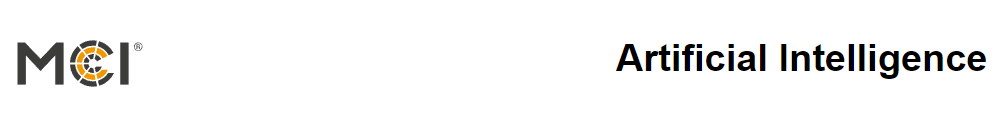

---
# 02 a Data Augmentation with SMOTE

Descriptive statistics play a crucial role in understanding datasets in machine learning by summarizing key characteristics of the data. These statistics include measures of central tendency such as mean, median, and mode, which help in understanding the data’s distribution. Additionally, dispersion metrics like standard deviation, variance, and interquartile range provide insights into the spread and variability of the dataset. Other important aspects include skewness and kurtosis, which describe the shape and asymmetry of the data distribution. Descriptive statistics are essential for data preprocessing, detecting anomalies, and making informed decisions before applying machine learning models. They help identify potential biases, missing values, and outliers, ensuring the dataset is clean and representative before training a model.

As always we want to explain things with an example. Therefore we start with some data we have from shooting in the sport of biathlon.

As always we import the relevant packages and libraries

In [1]:
from scipy.io import loadmat # to be able to load .fig files from MATLAB
import os # to be able to operate on files and folders
import pandas as pd # we need this to be able to create pandas dataframes
import matplotlib.pyplot as plt # we need this to be able to plot data
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns

Now we can load the data

In [3]:
df_score_csv = pd.read_csv("../Data/Biathlon_Shooting_Trigger/Full_Scores_Biathlon_2014_Complete_II.CSV",delimiter=';')

The data shows the score of an athlete on the shooting range. Lets have a look at the data comprehension

In [4]:
df_score_csv.info()
df_score_csv.describe()

<class 'pandas.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   trial   1095 non-null   str  
 1   score   1095 non-null   int64
dtypes: int64(1), str(1)
memory usage: 17.2 KB


,score
count,1095.000000
mean,7.399087
std,2.371101
min,0.000000
25%,6.000000
50%,8.000000
75%,9.000000
max,10.000000


There is a coloumn that says trial, which has embedded the information about the shooting pose (prone or standing) and load state (rested, loaded)

In [5]:
df_score_csv['prone'] = df_score_csv['trial'].str.contains('prone', case=False, na=False).astype(int)
df_score_csv['rest'] = df_score_csv['trial'].str.contains('rest', case=False, na=False).astype(int)
df_score_csv.info()
df_score_csv.describe()

<class 'pandas.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   trial   1095 non-null   str  
 1   score   1095 non-null   int64
 2   prone   1095 non-null   int64
 3   rest    1095 non-null   int64
dtypes: int64(3), str(1)
memory usage: 34.3 KB


,score,prone,rest
count,1095.000000,1095.000000,1095.000000
mean,7.399087,0.497717,0.602740
std,2.371101,0.500223,0.489554
min,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,8.000000,0.000000,1.000000
75%,9.000000,1.000000,1.000000
max,10.000000,1.000000,1.000000


#### TASK: Check how the distributions of the given variables are.

In [6]:
# your code goes here

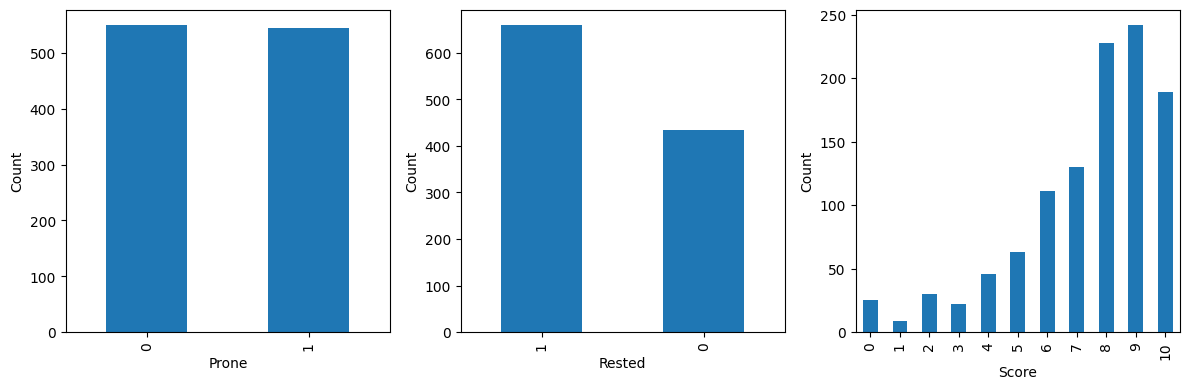

In [6]:
# You can also visualize these distributions using histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df_score_csv['prone'].value_counts().plot(kind='bar')
plt.xlabel('Prone')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
df_score_csv['rest'].value_counts().plot(kind='bar')
plt.xlabel('Rested')
plt.ylabel('Count')


plt.subplot(1, 3, 3)
df_score_csv['score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Of a total of 1095 shots taken, there are two different binary variables to consider (prone and rested). The score is given on a interval scale, ranging from 0 to 10 (11 values) and seems highly skewed.


#### TASK: Make a regression between prone & score as input and rested as output. Write your code below

In [7]:
# your code goes here

In [8]:
# Prepare the data
X = df_score_csv[['prone', 'score']]
y = df_score_csv['rest']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# You can also print the coefficients and intercept of the model
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Mean Squared Error: 0.22294475957676027
R-squared: 0.016134190829867667
Coefficients: [-0.17428343  0.06402263]
Intercept: 0.20606698296854659


## 1 Data Augmentation

The linear regression we have made above used an imbalanced output data. THis can be seen by the distribution and the counts of each pose

rest
1    660
0    435
Name: count, dtype: int64


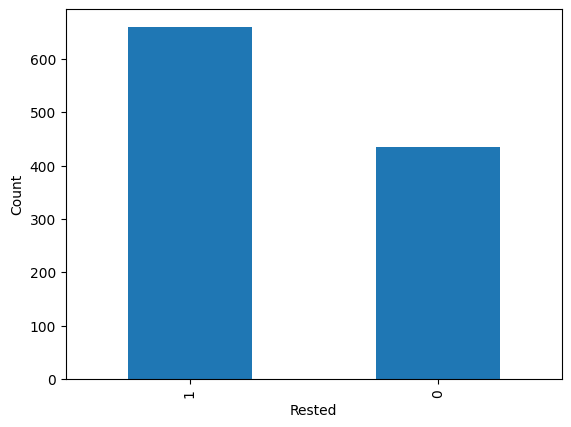

In [9]:
df_score_csv['rest'].value_counts().plot(kind='bar')
plt.xlabel('Rested')
plt.ylabel('Count')

print(df_score_csv['rest'].value_counts())

This implies, that the regression highly favours the rested state. It is possible, that we want this, but most of the time the linear regression should not favour any specific output (there are exceptions, e.g. if you have data with outliers, or you want to have a good regression in a specific range). A very common data augmentation methode is called SMOTE (Synthetic Minority Oversampling Technique). We want to apply it here to create a balanced dataset

rest
1    660
0    660
Name: count, dtype: int64


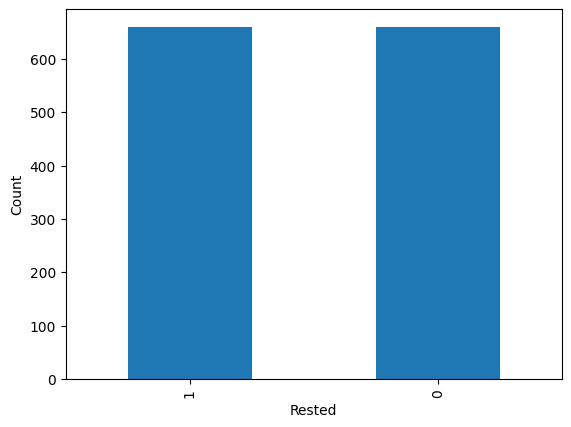

In [11]:
from imblearn.over_sampling import SMOTE

# Separate features (X) and target variable (y)
X = df_score_csv[['prone', 'score']]
y = df_score_csv['rest']

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)  # You can adjust random_state for reproducibility
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=['prone', 'score'])
df_resampled['rest'] = y_resampled

# Now df_resampled has a balanced 'rest' column
print(df_resampled['rest'].value_counts())

# You can visualize the balanced distribution:
df_resampled['rest'].value_counts().plot(kind='bar')
plt.xlabel('Rested')
plt.ylabel('Count')
plt.show()

The Output is now balanced, but what about the other data? How did they change?

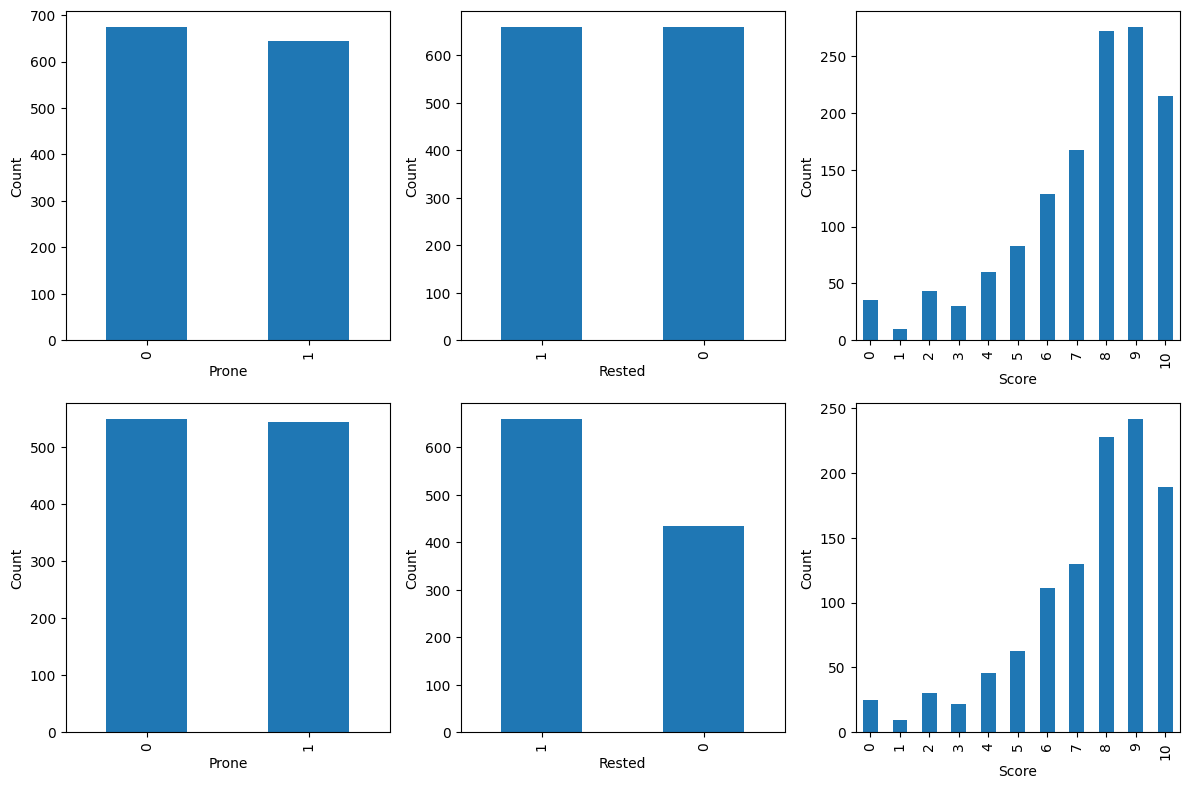

In [12]:
# You can also visualize these distributions using histograms
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
df_resampled['prone'].value_counts().plot(kind='bar')
plt.xlabel('Prone')
plt.ylabel('Count')

plt.subplot(2, 3, 2)
df_resampled['rest'].value_counts().plot(kind='bar')
plt.xlabel('Rested')
plt.ylabel('Count')


plt.subplot(2, 3, 3)
df_resampled['score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Score')
plt.ylabel('Count')

plt.subplot(2, 3, 4)
df_score_csv['prone'].value_counts().plot(kind='bar')
plt.xlabel('Prone')
plt.ylabel('Count')

plt.subplot(2, 3, 5)
df_score_csv['rest'].value_counts().plot(kind='bar')
plt.xlabel('Rested')
plt.ylabel('Count')


plt.subplot(2, 3, 6)
df_score_csv['score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Score')
plt.ylabel('Count')


plt.tight_layout()
plt.show()

#### TASK: Redo the regression with the resampled dataset and discuss the differences

In [13]:
# your code goes here

In [14]:
# @title
# Separate features (X) and target variable (y)
X = df_resampled[['prone', 'score']]
y = df_resampled['rest']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model_oversampled = LinearRegression()
model_oversampled.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# You can also print the coefficients and intercept of the model
print("\n")
print(f"Coefficients Augmented: {model_oversampled.coef_}")
print(f"Intercept Augmented: {model_oversampled.intercept_}")
print(f"Coefficients Raw: {model.coef_}")
print(f"Intercept Raw: {model.intercept_}")

Mean Squared Error: 0.25004473612331973
R-squared: -0.0006958328366861721


Coefficients Augmented: [-0.15288276  0.0635156 ]
Intercept Augmented: 0.11839341308460793
Coefficients Raw: [-0.17428343  0.06402263]
Intercept Raw: 0.20606698296854659
